# CS146 Final Project

## Modeling and forecasting atmospheric CO₂ from 1958 into the future

-------

## Data Early Checks and Reshaping

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import scipy.stats as sts
import io
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import pystan
import seaborn as sns

In [2]:
#Upload file with data
from google.colab import files 
uploaded = files.upload()

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo.csv


In [3]:
#Import data from Mauna Loa Observatory
imported_data = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo.csv']),names=['Date','CO2 ppm'])

In [4]:
#Take a look at the first entries
imported_data.head()

,Date,CO2 ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [5]:
#Sanity check
imported_data.describe()

,CO2 ppm
count,3210.000000
mean,356.334090
std,28.980326
min,313.040000
25%,330.130000
50%,353.310000
75%,379.947500
max,417.420000


In [6]:
#Compute t, number of days since measurements started in 1958
days_after_first_measurement = [0]
for i in range(0, len(imported_data)-1):
  days_after_first_measurement.append(days_after_first_measurement[-1]+ 
              abs((datetime.strptime(imported_data.iloc[i+1,0], "%Y-%m-%d") - 
                   datetime.strptime(imported_data.iloc[i,0], "%Y-%m-%d")).days))
#Include in data frame
imported_data['t'] = days_after_first_measurement

#Take a look at the first entries
imported_data.head()

,Date,CO2 ppm,t
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


In [7]:
#Sanity check
imported_data.describe()

,CO2 ppm,t
count,3210.000000,3210.000000
mean,356.334090,11626.044860
std,28.980326,6566.080573
min,313.040000,0.000000
25%,330.130000,5986.750000
50%,353.310000,11644.500000
75%,379.947500,17309.250000
max,417.420000,22967.000000


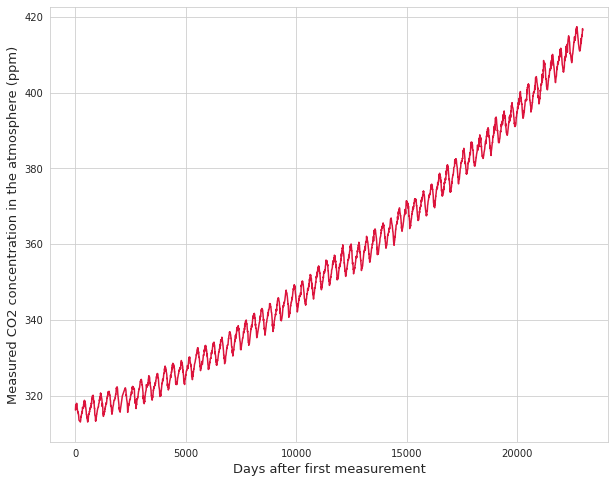

In [8]:
#Visualize measurement data
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson')
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.show()

## First Version of Linear Model 

In [12]:
#Stan code for linear model
stan_code_linear = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

    int<lower=0> N_obs;                 // Number of measurements
    
    // data collected
    real<lower=0> measurements[N_obs];  // CO2 ppm
    real<lower=0> t[N_obs];             // t, Days after first measurement
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0> c2;
    real<lower=0> c3;         
    real<lower=0> c4;            
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {

    //priors 
    c0 ~ cauchy(0, 10);
    c1 ~ cauchy(0, 10);
    c2 ~ cauchy(0, 10);
    c3 ~ cauchy(0, 10);
    c4 ~ cauchy(0, 10);

    //likelihood function
    for (i in 1:N_obs) {
      measurements[i] ~ normal(c0+c1*t[i]+c2*cos(2*pi()*t[i]/(365.25+c3)), c4);
    }

}
"""

In [13]:
#Compile code for model
stan_model_linear = pystan.StanModel(model_code=stan_code_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66516250502160067cd23563ed4832f1 NOW.


In [14]:
#input data
stan_data = {
  'N_obs': len(imported_data),
  'measurements': imported_data.iloc[:,1],
  't': imported_data.iloc[:,2]
}


In [15]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results_linear = stan_model_linear.sampling(data=stan_data)
print(stan_results_linear)

Inference for Stan model: anon_model_66516250502160067cd23563ed4832f1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   305.64  2.4e-3   0.14 305.35 305.54 305.64 305.74 305.92   3778    1.0
c1   4.4e-3  1.7e-7 1.1e-5 4.3e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   4036    1.0
c2     2.16    0.72   1.02   0.26   1.48   2.71   2.79   2.93      2  10.56
c3      2.3    2.19    3.1   0.41    0.5   0.55   3.98   8.05      2  20.04
c4     4.14    0.13   0.19   3.94   4.01   4.05   4.26   4.53      2   4.21
lp__  -6162  100.69 142.44  -6411  -6264  -6080  -6079  -6078      2  95.37

Samples were drawn using NUTS at Tue Apr 20 19:46:41 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [16]:
# Extract the generated samples from the stan model
posterior_samples_linear = stan_results_linear.extract()

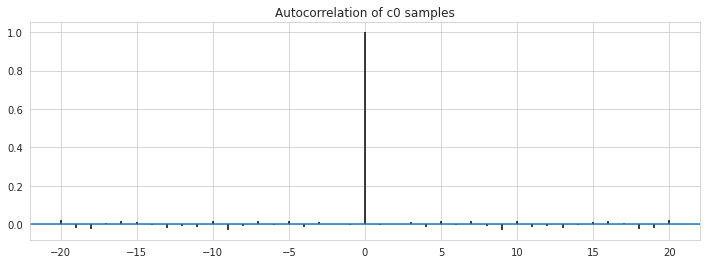

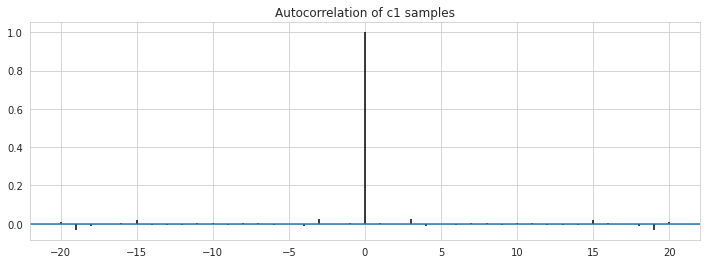

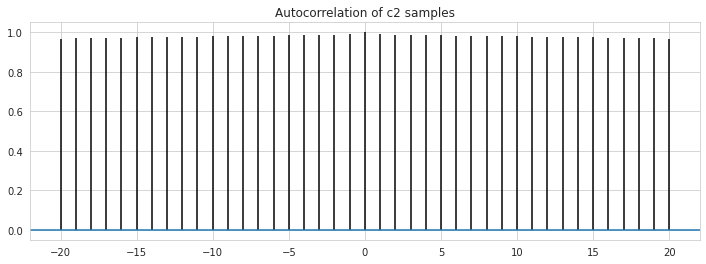

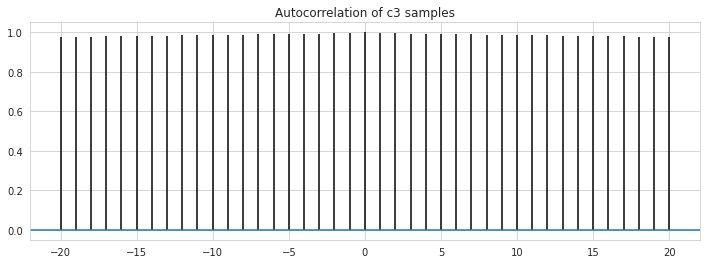

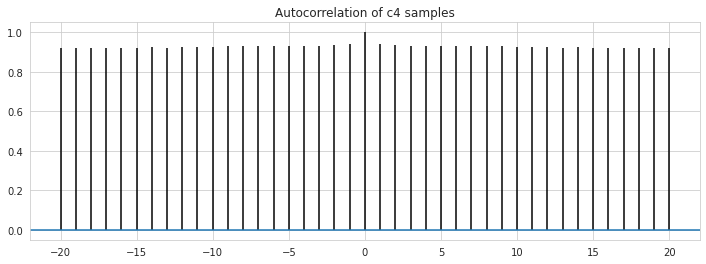

In [22]:
# Code from class resources
# Plot sample autocorrelation for each parameter.

parameters = ['c0','c1','c2','c3','c4']

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_linear[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


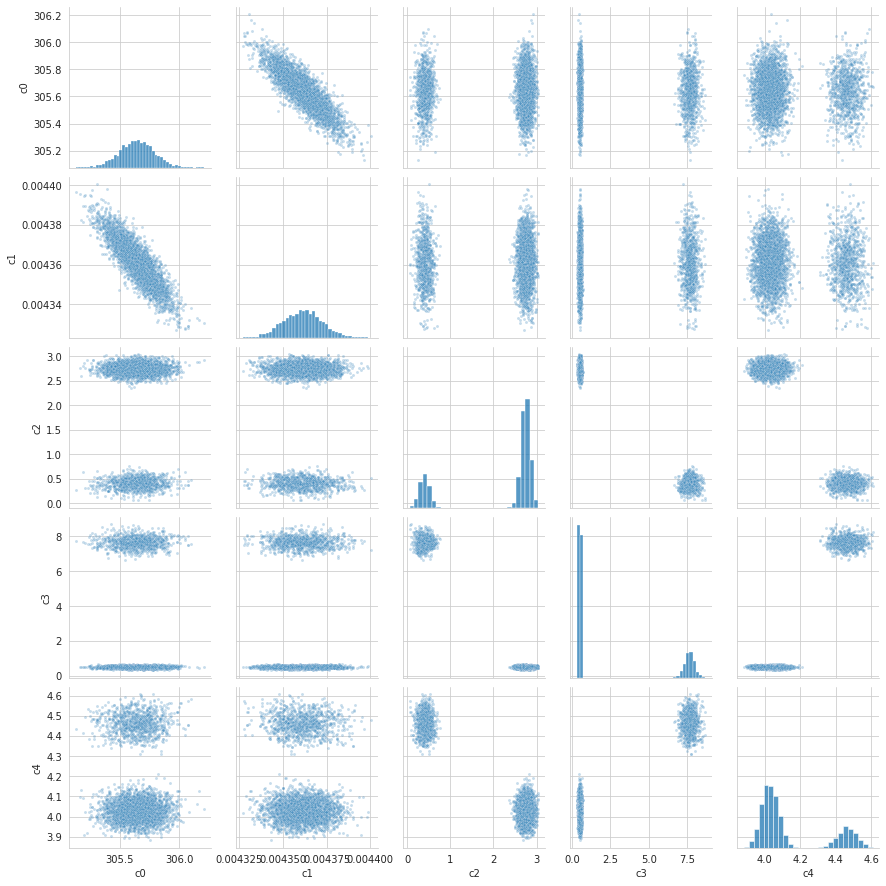

In [25]:
# Code from class resources
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([posterior_samples_linear[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## Second Version of Linear Model

In [77]:
#Stan code for linear model
stan_code_linear = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

    int<lower=0> N_obs;                 // Number of measurements
    
    // data collected
    real<lower=0> measurements[N_obs];  // CO2 ppm
    real<lower=0> t[N_obs];             // t, Days after first measurement
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=5> c3;         
    real<lower=0> c4;            
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {

    //priors 
    c0 ~ cauchy(0, 10);
    c1 ~ cauchy(0, 10);
    c2 ~ cauchy(0, 10);
    c3 ~ cauchy(0, 10);
    c4 ~ cauchy(0, 10);

    //likelihood function
    for (i in 1:N_obs) {
      measurements[i] ~ normal(c0+c1*t[i]+c2*cos(2*pi()*t[i]/(365.25+c3)), c4);
    }

}
"""

In [117]:
#Compile code for model
stan_model_linear = pystan.StanModel(model_code=stan_code_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d21b89b006e652140f18c6eb036d9124 NOW.


In [ ]:
#input data
stan_data = {
  'N_obs': len(imported_data),
  'measurements': imported_data.iloc[:,1],
  't': imported_data.iloc[:,2]
}


In [ ]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results_linear = stan_model_linear.sampling(data=stan_data)
print(stan_results_linear)

In [ ]:
# Extract the generated samples from the stan model
posterior_samples_linear = stan_results_linear.extract()

In [ ]:
# Code from class resources
# Plot sample autocorrelation for each parameter.

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_linear[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

In [ ]:
# Code from class resources
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([posterior_samples_linear[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
linear_model_data = np.array(sts.norm.rvs(np.mean(posterior_samples_linear['c0'])+
                                np.mean(posterior_samples_linear['c1'])*imported_data.iloc[:,2]+ 
                                np.mean(posterior_samples_linear['c2'])*np.cos((2*np.pi*imported_data.iloc[:,2])/365.25+
                                np.mean(posterior_samples_linear['c3'])), 
                                  np.mean(posterior_samples_linear['c4'])))


In [ ]:
#Visualize and compare model results and actual measurements
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.plot(days_after_first_measurement, linear_model_data, color='limegreen', label= 'Modeled trend using STAN Posteriors over parameters')
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label= 'Real Measurements')
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.legend()
plt.show()

## Second Model (Quadratic Long-term Change)

In [55]:
#Stan code for quadratic model
stan_code_quad = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

    int<lower=0> N_obs;                 // Number of measurements
    
    // data collected
    real<lower=0> measurements[N_obs];  // CO2 ppm
    real<lower=0> t[N_obs];             // t, Days after first measurement
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=5> c3;         
    real<lower=0> c4;            
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {

    //priors 
    c0 ~ cauchy(0, 10);
    c1 ~ cauchy(0, 10);
    c2 ~ cauchy(0, 10);
    c3 ~ cauchy(0, 10);
    c4 ~ cauchy(0, 10);

    //likelihood function
    for (i in 1:N_obs) {
      measurements[i] ~ normal(c0+c1*(t[i]^2)+c2*cos(2*pi()*t[i]/(365.25+c3)), c4);
    }

}
"""

In [56]:
#Compile code for model
stan_model_quad = pystan.StanModel(model_code=stan_code_quad)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c04feeaea8c5c9642d86769234d0fdde NOW.


In [57]:
#input data
stan_data = {
  'N_obs': len(imported_data),
  'measurements': imported_data.iloc[:,1],
  't': imported_data.iloc[:,2]
}


In [118]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results_quad = stan_model_quad.sampling(data=stan_data)
print(stan_results_quad)

Inference for Stan model: anon_model_c04feeaea8c5c9642d86769234d0fdde.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   323.78  1.5e-3     0.1  323.6 323.72 323.78 323.85 323.97   4143    1.0
c1   1.8e-7 6.4e-12 4.0e-10 1.8e-7 1.8e-7 1.8e-7 1.8e-7 1.8e-7   3938    1.0
c2      2.8  1.6e-3    0.09   2.64   2.75    2.8   2.86   2.97   2799    1.0
c3     0.54  9.5e-4    0.05   0.44    0.5   0.54   0.57   0.63   2591    1.0
c4     3.52  8.6e-4    0.04   3.43   3.49   3.52   3.55   3.61   2474    1.0
lp__  -5656    0.04    1.57  -5660  -5657  -5655  -5655  -5654   1453   1.01

Samples were drawn using NUTS at Wed Apr 21 01:35:59 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [59]:
# Extract the generated samples from the stan model
posterior_samples_quad = stan_results_quad.extract()

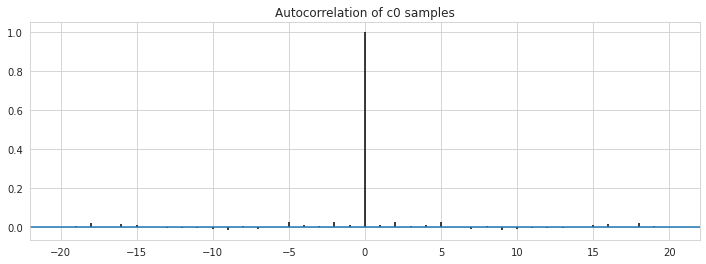

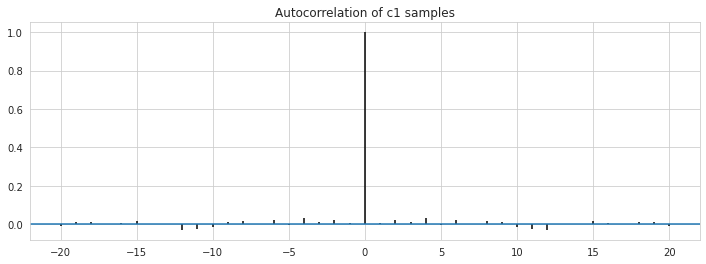

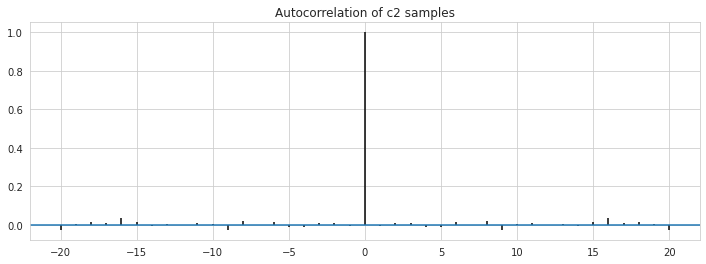

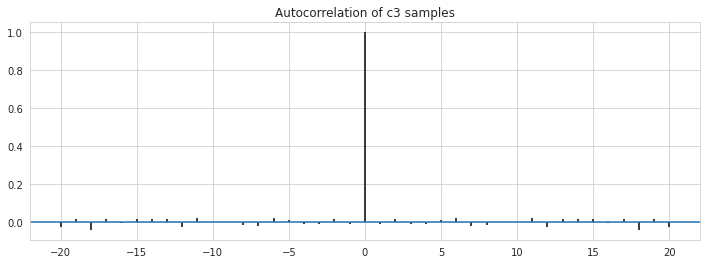

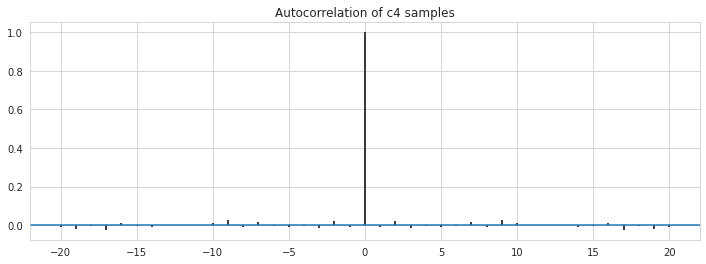

In [60]:
# Code from class resources
# Plot sample autocorrelation for each parameter.

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_quad[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


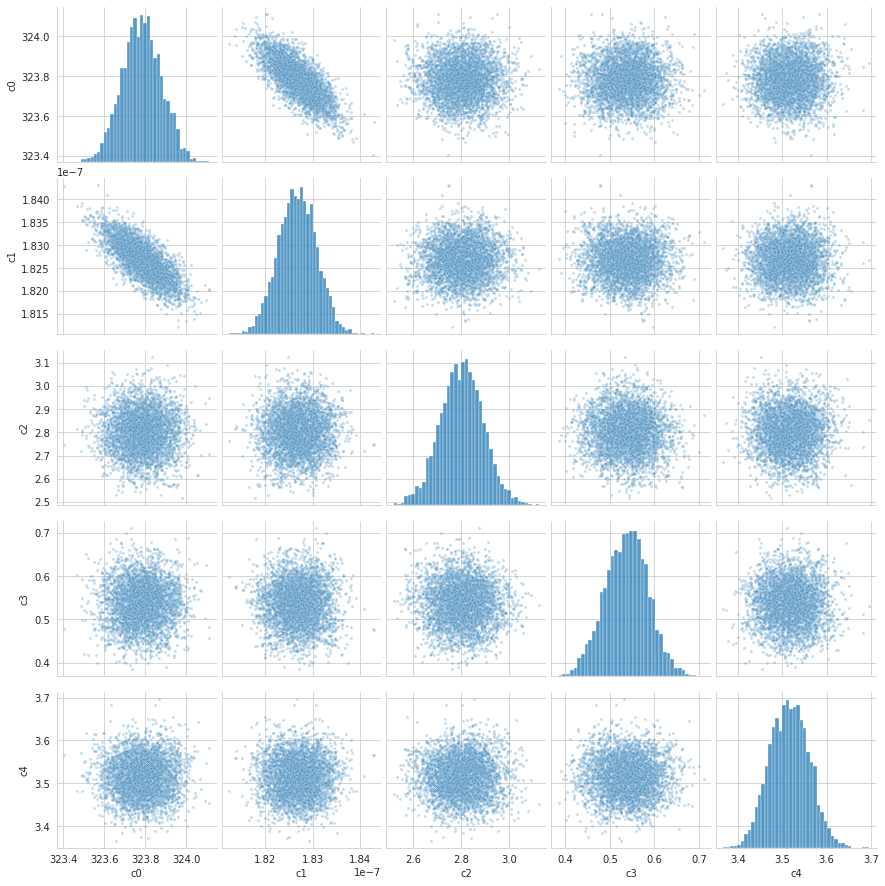

In [61]:
# Code from class resources
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([posterior_samples_quad[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [64]:
quad_model_data = np.array(sts.norm.rvs(np.mean(posterior_samples_quad['c0'])+
                                np.mean(posterior_samples_quad['c1'])*(imported_data.iloc[:,2]**2)+ 
                                np.mean(posterior_samples_quad['c2'])*np.cos((2*np.pi*imported_data.iloc[:,2])/365.25+
                                np.mean(posterior_samples_quad['c3'])), 
                                  np.mean(posterior_samples_quad['c4'])))


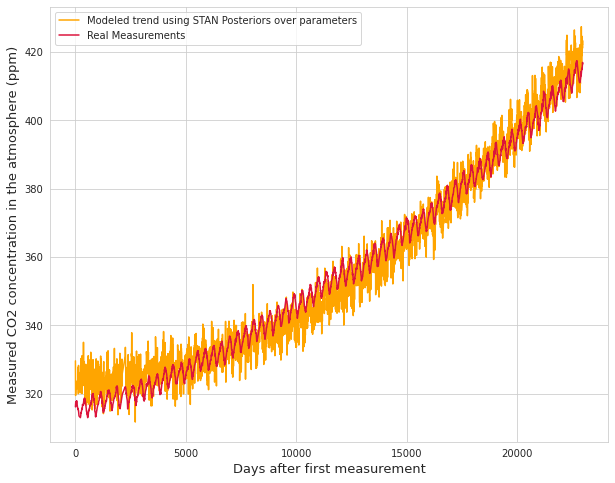

In [65]:
#Visualize and compare model results and actual measurements
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.plot(days_after_first_measurement, quad_model_data, color='orange', label= 'Modeled trend using STAN Posteriors over parameters')
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label= 'Real Measurements')
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.legend()
plt.show()

## Third Model (Exponential Long-term Change)

In [9]:
#Stan code for exponential model
stan_code_exp = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

    int<lower=0> N_obs;                 // Number of measurements
    
    // data collected
    real<lower=0> measurements[N_obs];  // CO2 ppm
    real<lower=0> t[N_obs];             // t, Days after first measurement
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=5> c3;         
    real<lower=0> c4;            
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {

    //priors 
    c0 ~ cauchy(0, 10);
    c1 ~ cauchy(0, 10);
    c2 ~ cauchy(0, 10);
    c3 ~ cauchy(0, 10);
    c4 ~ cauchy(0, 10);

    //likelihood function
    for (i in 1:N_obs) {
      measurements[i] ~ normal(c0+c1*(t[i]^1.5)+c2*cos(2*pi()*t[i]/(365.25+c3)), c4);
    }

}
"""

In [10]:
#Compile code for model
stan_model_exp = pystan.StanModel(model_code=stan_code_exp)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3979a6ad7609b961c0a67ccb3591cb1b NOW.


In [11]:
#input data
stan_data = {
  'N_obs': len(imported_data),
  'measurements': imported_data.iloc[:,1],
  't': imported_data.iloc[:,2]
}


In [12]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results_exp = stan_model_exp.sampling(data=stan_data)
print(stan_results_exp)

Inference for Stan model: anon_model_3979a6ad7609b961c0a67ccb3591cb1b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   317.14  5.6e-4   0.04 317.07 317.12 317.14 317.17 317.21   4120    1.0
c1   2.8e-5 3.3e-10 2.1e-8 2.8e-5 2.8e-5 2.8e-5 2.8e-5 2.8e-5   4057    1.0
c2     2.77  7.1e-4   0.03   2.71   2.75   2.77   2.79   2.84   1871    1.0
c3     0.53  3.8e-4   0.02   0.49   0.52   0.53   0.54   0.56   1903    1.0
c4     1.22  3.5e-4   0.02   1.19   1.21   1.22   1.23   1.25   2005    1.0
lp__  -2262    0.04   1.55  -2266  -2263  -2262  -2261  -2260   1370    1.0

Samples were drawn using NUTS at Wed Apr 21 17:50:08 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [13]:
# Extract the generated samples from the stan model
posterior_samples_exp = stan_results_exp.extract()

In [15]:
#Define parameters and function
parameters = ['c0','c1','c2','c3','c4']

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


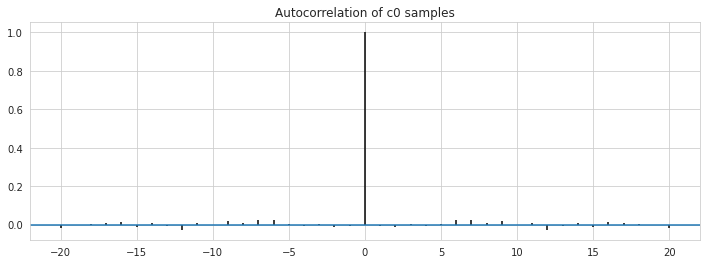

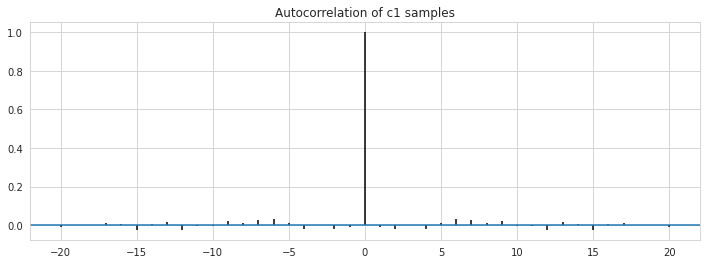

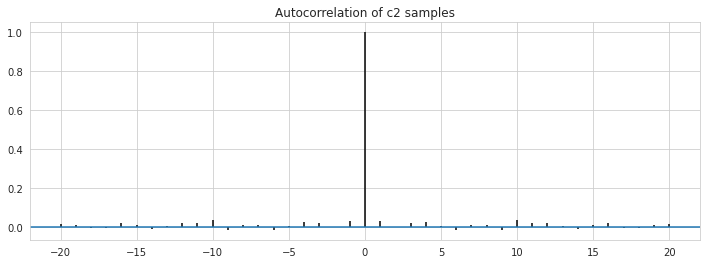

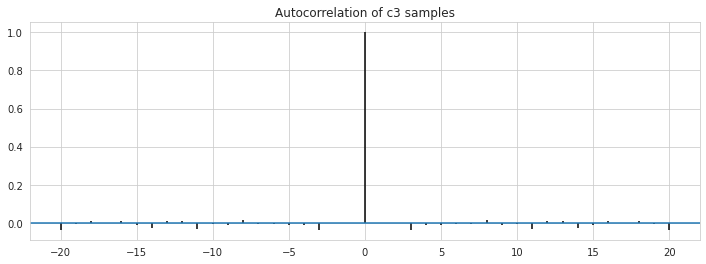

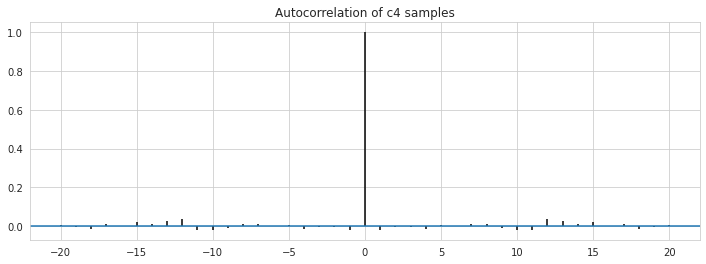

In [16]:
# Code from class resources
# Plot sample autocorrelation for each parameter.

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_exp[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


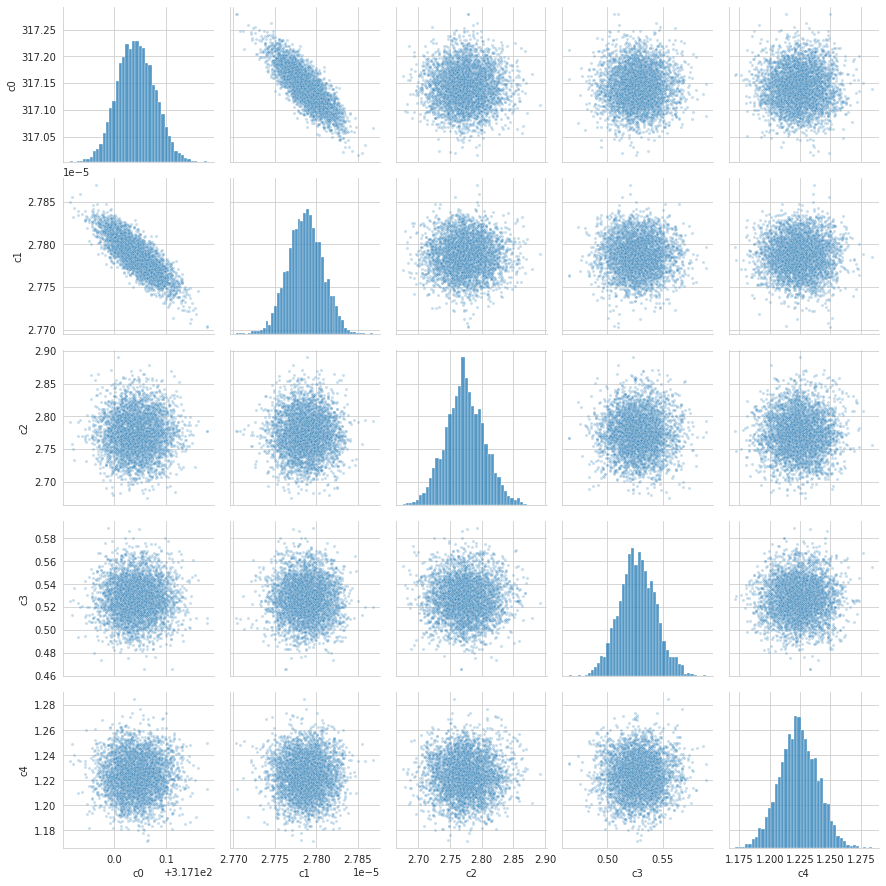

In [17]:
# Code from class resources
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([posterior_samples_exp[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [18]:
#Get new data set
exp_model_data = np.array(sts.norm.rvs(np.mean(posterior_samples_exp['c0'])+
                                np.mean(posterior_samples_exp['c1'])*(imported_data.iloc[:,2]**1.5)+ 
                                np.mean(posterior_samples_exp['c2'])*np.cos((2*np.pi*imported_data.iloc[:,2])/365.25+
                                np.mean(posterior_samples_exp['c3'])), 
                                  np.mean(posterior_samples_exp['c4'])))


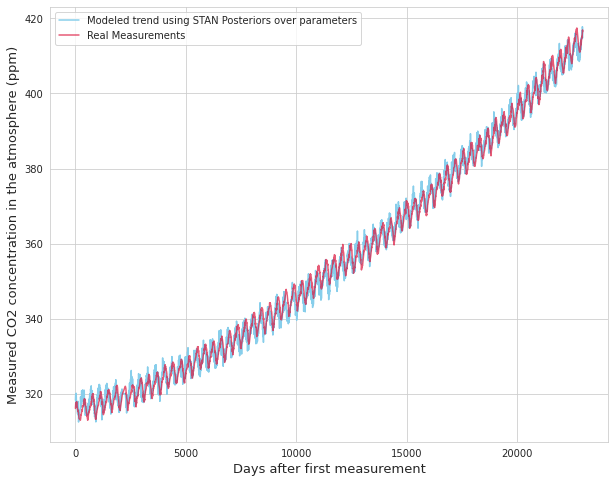

In [19]:
#Visualize and compare model results and actual measurements
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
plt.plot(days_after_first_measurement, exp_model_data, color='skyblue', label= 'Modeled trend using STAN Posteriors over parameters')
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label= 'Real Measurements', alpha=0.7)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.legend()
plt.show()

In [ ]:
#Visualize and compare model results and actual measurements
plt.figure(figsize=(12,10))
sns.set_style("whitegrid")
plt.plot(days_after_first_measurement, linear_model_data, color='limegreen', label= 'Modeled trend with linear long-term increase',alpha=0.3)
plt.plot(days_after_first_measurement, quad_model_data, color='orange', label= 'Modeled trend with quadratic long-term increase',alpha=0.3)
plt.plot(days_after_first_measurement, exp_model_data, color='blue', label= 'Modeled trend with exponential (exp=1.5) long-term increase',alpha=0.5)
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label= 'Real Measurements', alpha=0.7)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.legend()
plt.show()

## Posterior Predictive Checks

In [91]:
#defining the test statistics for posterior predictive checks
def test_statistic1(data):
  return data[1500]-data[0]

def test_statistic2(data):
  return data[-1] - data[-1500]

In [97]:
#For keeping data
test_statistics1_linear = []
test_statistics2_linear = []

for i in range(1000): #Create a distribution of 1000 measurements (from 1000 samples)
  linear_model_data = np.array(sts.norm.rvs(np.mean(posterior_samples_linear['c0'])+
                                  np.mean(posterior_samples_linear['c1'])*imported_data.iloc[:,2]+ 
                                  np.mean(posterior_samples_linear['c2'])*np.cos((2*np.pi*imported_data.iloc[:,2])/365.25+
                                  np.mean(posterior_samples_linear['c3'])), 
                                    np.mean(posterior_samples_linear['c4'])))
  #Measure both test statistics
  test_statistics1_linear.append(test_statistic1(linear_model_data))
  test_statistics2_linear.append(test_statistic2(linear_model_data))

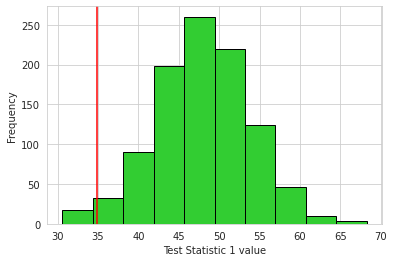

P-value =  0.982


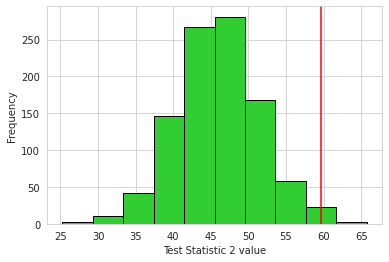

P-value =  0.01


In [114]:
#Plot distributions over test statisitcs
plt.hist(test_statistics1_linear, edgecolor='black', color='limegreen')
plt.xlabel('Test Statistic 1 value')
plt.ylabel('Frequency')
plt.axvline(test_statistic1(list(imported_data.iloc[:,1])), color='red')
plt.show()

#Compute p-value
count = 0
for i in test_statistics1_linear:
  if i>test_statistic1(list(imported_data.iloc[:,1])):
    count+=1
print('P-value = ', count/1000)

plt.hist(test_statistics2_linear, edgecolor='black', color='limegreen')
plt.xlabel('Test Statistic 2 value')
plt.ylabel('Frequency')
plt.axvline(test_statistic2(list(imported_data.iloc[:,1])), color='red')
plt.show()

#Compute p-value
count = 0
for i in test_statistics2_linear:
  if i>test_statistic2(list(imported_data.iloc[:,1])):
    count+=1
print('P-value = ', count/1000)

In [109]:
#For keeping data
test_statistics1_quad = []
test_statistics2_quad = []

for i in range(1000): #Create a distribution of 1000 measurements (from 1000 samples)
  quad_model_data = np.array(sts.norm.rvs(np.mean(posterior_samples_quad['c0'])+
                                np.mean(posterior_samples_quad['c1'])*(imported_data.iloc[:,2]**2)+ 
                                np.mean(posterior_samples_quad['c2'])*np.cos((2*np.pi*imported_data.iloc[:,2])/365.25+
                                np.mean(posterior_samples_quad['c3'])), 
                                  np.mean(posterior_samples_quad['c4'])))
  #Measure both test statistics
  test_statistics1_quad.append(test_statistic1(quad_model_data))
  test_statistics2_quad.append(test_statistic2(quad_model_data))

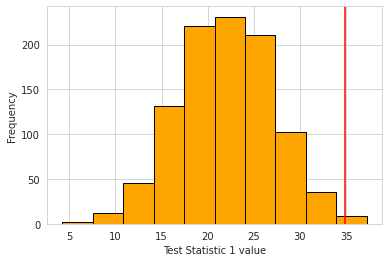

P-value =  0.005


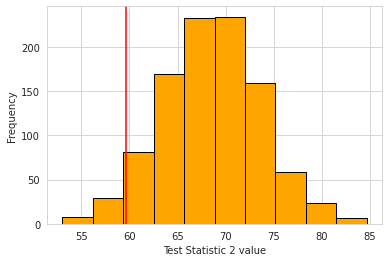

P-value =  0.958


In [115]:
#Plot distributions over test statisitcs
plt.hist(test_statistics1_quad, edgecolor='black', color='orange')
plt.xlabel('Test Statistic 1 value')
plt.ylabel('Frequency')
plt.axvline(test_statistic1(list(imported_data.iloc[:,1])), color='red')
plt.show()

#Compute p-value
count = 0
for i in test_statistics1_quad:
  if i>test_statistic1(list(imported_data.iloc[:,1])):
    count+=1
print('P-value = ', count/1000)

plt.hist(test_statistics2_quad, edgecolor='black', color='orange')
plt.xlabel('Test Statistic 2 value')
plt.ylabel('Frequency')
plt.axvline(test_statistic2(list(imported_data.iloc[:,1])), color='red')
plt.show()

#Compute p-value
count = 0
for i in test_statistics2_quad:
  if i>test_statistic2(list(imported_data.iloc[:,1])):
    count+=1
print('P-value = ', count/1000)

In [112]:
#For keeping data
test_statistics1_exp = []
test_statistics2_exp = []

for i in range(1000): #Create a distribution of 1000 measurements (from 1000 samples)
  exp_model_data = np.array(sts.norm.rvs(np.mean(posterior_samples_exp['c0'])+
                                np.mean(posterior_samples_exp['c1'])*(imported_data.iloc[:,2]**1.5)+ 
                                np.mean(posterior_samples_exp['c2'])*np.cos((2*np.pi*imported_data.iloc[:,2])/365.25+
                                np.mean(posterior_samples_exp['c3'])), 
                                  np.mean(posterior_samples_exp['c4'])))
  #Measure both test statistics
  test_statistics1_exp.append(test_statistic1(exp_model_data))
  test_statistics2_exp.append(test_statistic2(exp_model_data))

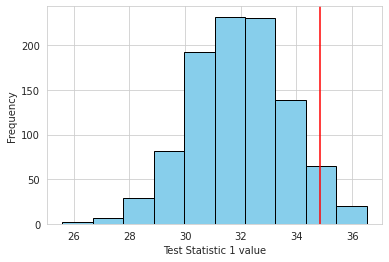

P-value =  0.044


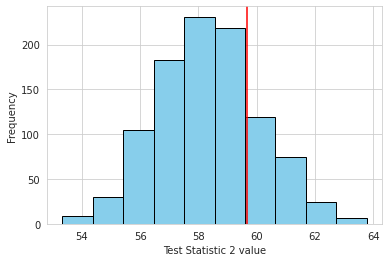

P-value =  0.218


In [116]:
#Plot distributions over test statisitcs
plt.hist(test_statistics1_exp, edgecolor='black', color='skyblue')
plt.xlabel('Test Statistic 1 value')
plt.ylabel('Frequency')
plt.axvline(test_statistic1(list(imported_data.iloc[:,1])), color='red')
plt.show()

#Compute p-value
count = 0
for i in test_statistics1_exp:
  if i>test_statistic1(list(imported_data.iloc[:,1])):
    count+=1
print('P-value = ', count/1000)

plt.hist(test_statistics2_exp, edgecolor='black', color='skyblue')
plt.xlabel('Test Statistic 2 value')
plt.ylabel('Frequency')
plt.axvline(test_statistic2(list(imported_data.iloc[:,1])), color='red')
plt.show()

#Compute p-value
count = 0
for i in test_statistics2_exp:
  if i>test_statistic2(list(imported_data.iloc[:,1])):
    count+=1
print('P-value = ', count/1000)

In [241]:
#Create an array with the days when the measurements will be taken in the future
future = np.arange(imported_data.iloc[-1, 2]+7, imported_data.iloc[-1, 2]+15007, 7)

#Creates data frames to store data
current_days = pd.DataFrame({'Column 1':days_after_first_measurement})
future_days = pd.DataFrame({'Column 2':future})

#Merges data frames into one
prediction_data_ = current_days['Column 1'].append(future_days['Column 2']).reset_index(drop=True)
prediction_data = prediction_data_.to_frame()
prediction_data['CO2'] = imported_data.iloc[:,1]

In [229]:
#Stan code for exponential model --> prediction
stan_code_exp_fore = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  
    int<lower=0> N_obs;      // length of the data (number of prices)
    int<lower=0> N_fore;    // number of future days
    real<lower=0> measurements[N_obs];   // specific observations
    real<lower=0> t[N_obs];       // day
    real<lower=0> day_future[N_fore];  //futuure days for which we need to create data
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=15> c3;          
    real<lower=0> c4;            
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {
    //priors 
    c0 ~ cauchy(0, 10);
    c1 ~ cauchy(0, 10); 
    c2 ~ cauchy(0, 10);
    c3 ~ cauchy(0, 10);
    c4 ~ cauchy(0, 10);

    //likelihood
    for (i in 1:N_obs) {
      measurements[i] ~ normal(c0+c1*(t[i]^1.5)+c2*cos(2*pi()*t[i]/(365.25+c3)), c4);
    }

}

generated quantities {
  real x_future[N_fore];
  for(j in 1:N_fore) {
    x_future[j] = normal_rng(c0+c1*(day_future[j]^1.5)+c2*cos(2*pi()*day_future[j]/(365.25+c3)), 
    c4);
  }
}
"""


In [230]:
#Compile code for model
stan_model_exp_fore = pystan.StanModel(model_code=stan_code_exp_fore)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_62eda5774a91c7a15799a1aa663ccd5f NOW.


In [233]:
#Data for Bayesian inference in STAN
stan_data_exp_fore = {
  'N_obs': len(imported_data),
  'N_fore': len(future_days),
  'measurements': prediction_data.iloc[:3210,1],
  't': prediction_data.iloc[:3210,0],
  'day_future': prediction_data.iloc[3210:,0]
}

In [234]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
results_exp_fore = stan_model_exp_fore.sampling(data=stan_data_exp_fore)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [235]:
# Extract the generated samples from the stan model
samples_exp_fore = results_exp_fore.extract()

In [266]:
len(predictions[3999])

2143

In [242]:
#Now compute means and 95% CI for each measurement
predictions = samples_exp_fore['x_future']
prediction_interval = np.percentile(predictions, axis=0, q=[2.5, 97.5])


forecast_values = []
for i in range(len(predictions[0])):
  val = 0
  for k in range(4000):
    val+=predictions[k][i]
  forecast_values.append(val/4000)


In [243]:
#generating dats for each day in the future to add them to a new table
dates = ['2021-02-13']
for i in range(len(future_days)):
  begindatestr = dates[-1]
  begindate = datetime.strptime(begindatestr, "%Y-%m-%d")
  enddate = begindate + timedelta(days=7)
  dates.append(datetime.strftime(enddate, "%Y-%m-%d"))

In [246]:
#updating the prediction dataset for better readibility
prediction_data['Date'] = list(imported_data.iloc[:, 0])+dates[1:]
prediction_data.columns =['t', 'CO2', 'Date']
prediction_data

,t,CO2,Date
0,0,316.19,1958-03-29
1,7,317.31,1958-04-05
2,14,317.69,1958-04-12
3,21,317.58,1958-04-19
4,28,316.48,1958-04-26
...,...,...,...
5348,37940,NaN,2062-02-11
5349,37947,NaN,2062-02-18
5350,37954,NaN,2062-02-25
5351,37961,NaN,2062-03-04


In [262]:
prediction_data[:4000]

,t,CO2,Date
0,0,316.19,1958-03-29
1,7,317.31,1958-04-05
2,14,317.69,1958-04-12
3,21,317.58,1958-04-19
4,28,316.48,1958-04-26
...,...,...,...
3995,28469,NaN,2036-03-08
3996,28476,NaN,2036-03-15
3997,28483,NaN,2036-03-22
3998,28490,NaN,2036-03-29


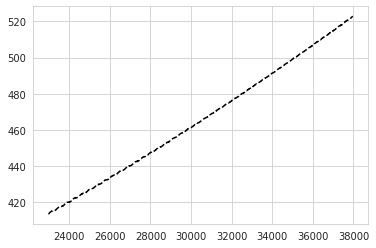

In [252]:
plt.plot(future_days, forecast_values, 'k--', label='Predicted data')

In [253]:
days_after_first_measurement[-1]

22967

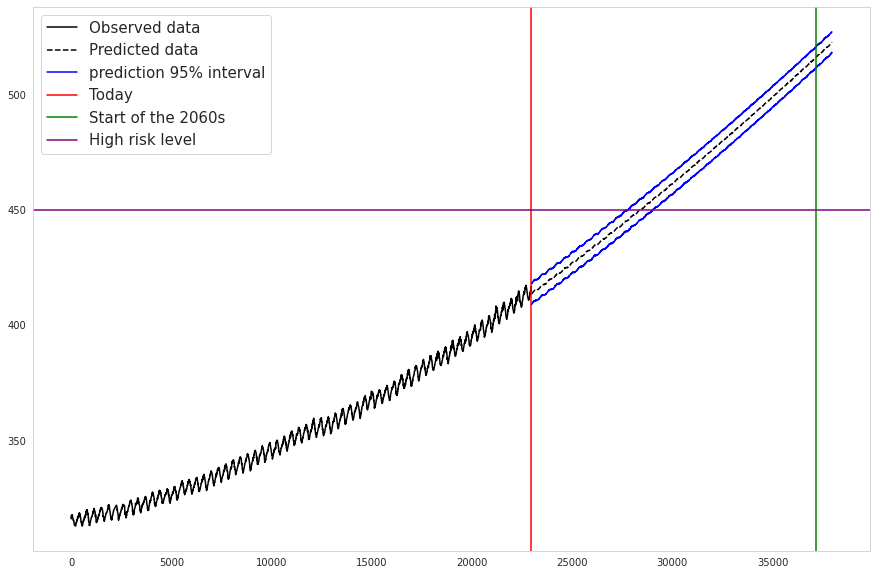

In [254]:
#plotting the main prediction figure along with 95% confidence intervals
plt.figure(figsize=(15,10))
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], 'k-', label='Observed data')
plt.plot(future_days, forecast_values, 'k--', label='Predicted data')
plt.plot(
    range(days_after_first_measurement[-1], 37968, 7), prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    range(days_after_first_measurement[-1], 37968, 7), prediction_interval[1,:],
    'b-')
plt.axvline(days_after_first_measurement[-1], color='red', label='Today')
plt.axvline(37163, color='green', label='Start of the 2060s')
plt.axhline(450, color='purple', label='High risk level')
plt.grid()
plt.legend(fontsize=15)
plt.show()

## Forecasting CO2 concentrations over the next 40 years


In [21]:
#Create an array with the days when the measurements will be taken in the future
future = np.arange(imported_data.iloc[-1, 2]+7, imported_data.iloc[-1, 2]+15014, 7)

#Creates data frames to store data
current_days = pd.DataFrame({'Column 1':days_after_first_measurement})
future_days = pd.DataFrame({'Column 2':future})

#Merges data frames into one
prediction_data_ = current_days['Column 1'].append(future_days['Column 2']).reset_index(drop=True)
prediction_data = prediction_data_.to_frame()
prediction_data['CO2'] = imported_data.iloc[:,1]

In [22]:
#Stan code for exponential model --> prediction
stan_code_exp_fore = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  
    int<lower=0> N_obs;                  // Number of measurements
    int<lower=0> N_fore; 

    // data 
    real<lower=0> measurements[N_obs];   // CO2 ppm
    real<lower=0> t[N_obs];              // t, Days after first measurement
    real<lower=0> day_future[N_fore];    // Future ts
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    //parameters of the model
    real<lower=0> c0;   
    real<lower=0> c1;  
    real<lower=0, upper=10> c2;
    real<lower=0, upper=5> c3;          
    real<lower=0> c4;            
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.

model {
    //priors 
    c0 ~ cauchy(0, 10);
    c1 ~ cauchy(0, 10); 
    c2 ~ cauchy(0, 10);
    c3 ~ cauchy(0, 10);
    c4 ~ cauchy(0, 10);

    //likelihood
    for (i in 1:N_obs) {
      measurements[i] ~ normal(c0+c1*(t[i]^1.5)+c2*cos(2*pi()*t[i]/(365.25+c3)), c4);
    }

}

generated quantities {
  real x_future[N_fore];
  for(j in 1:N_fore) {
    x_future[j] = normal_rng(c0+c1*(day_future[j]^1.5)+c2*cos(2*pi()*day_future[j]/(365.25+c3)), 
    c4);
  }
}
"""
#Compile code for model
stan_model_exp_fore = pystan.StanModel(model_code=stan_code_exp_fore)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_32f9a247f1daf770dbd448c2301b496e NOW.


In [23]:
#Data for Bayesian inference in STAN

stan_data_exp_fore = {
  'N_obs': len(imported_data),
  'N_fore': len(future_days),
  'measurements': prediction_data.iloc[:3210,1],
  't': prediction_data.iloc[:3210,0],
  'day_future': prediction_data.iloc[3210:,0]
}

# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
results_exp_fore = stan_model_exp_fore.sampling(data=stan_data_exp_fore)

# Extract the generated samples from the stan model
samples_predictive = results_exp_fore.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [24]:
#Now compute means and 95% CI for each measurement
prediction = samples_predictive['x_future']
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

In [25]:
#Array for storing values
prediction_values = []
for i in range(len(prediction[0])):
  value = 0
  for k in range(4000):
    value+=prediction[k][i]
  prediction_values.append(value/4000)

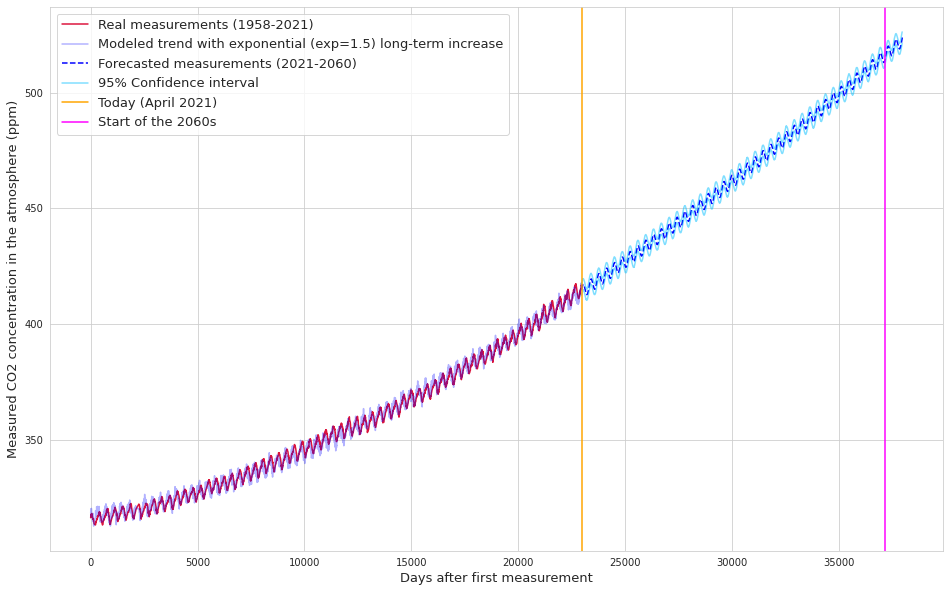

In [28]:
#Visualize modeled values + predictions
plt.figure(figsize=(16,10))
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label='Real measurements (1958-2021)')
plt.plot(days_after_first_measurement, exp_model_data, color='blue',
         label= 'Modeled trend with exponential (exp=1.5) long-term increase',alpha=0.3)
plt.plot(future_days, prediction_values, 'b--', label='Forecasted measurements (2021-2060)')
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[0,:],
         label='95% Confidence interval',color='deepskyblue', alpha=0.5) 
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[1,:],
         color='deepskyblue', alpha=0.5)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)

plt.axvline(days_after_first_measurement[-1], color='orange', label='Today (April 2021)')
plt.axvline(37163, color='fuchsia', label='Start of the 2060s')
sns.set_style("whitegrid")
plt.legend(fontsize=13)
plt.show()

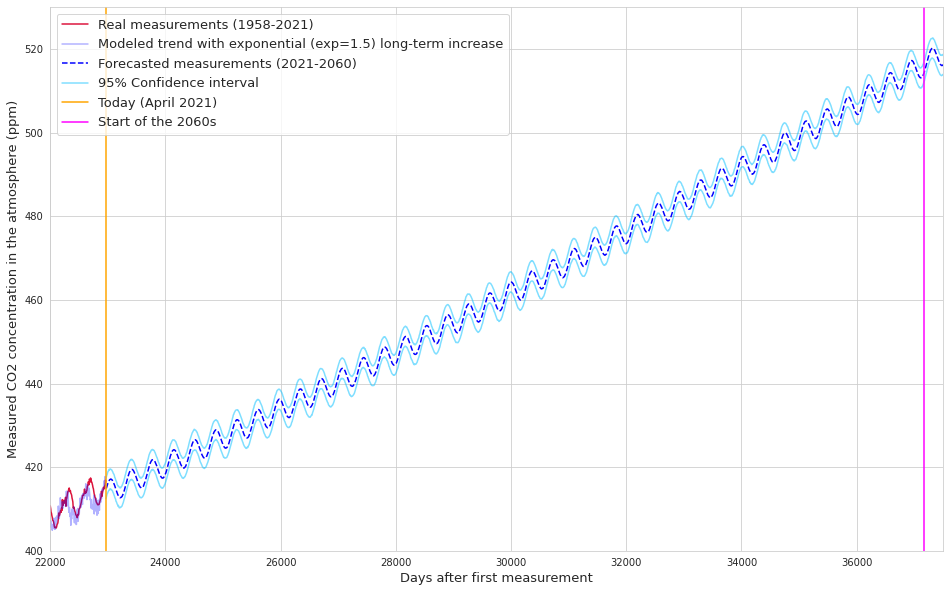

In [45]:
#Visualize modeled values + predictions
plt.figure(figsize=(16,10))
plt.axis([22000, 37500, 400, 530])
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label='Real measurements (1958-2021)')
plt.plot(days_after_first_measurement, exp_model_data, color='blue',
         label= 'Modeled trend with exponential (exp=1.5) long-term increase',alpha=0.3)
plt.plot(future_days, prediction_values, 'b--', label='Forecasted measurements (2021-2060)')
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[0,:],
         label='95% Confidence interval',color='deepskyblue', alpha=0.5) 
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[1,:],
         color='deepskyblue', alpha=0.5)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)

plt.axvline(days_after_first_measurement[-1], color='orange', label='Today (April 2021)')
plt.axvline(37163, color='fuchsia', label='Start of the 2060s')
sns.set_style("whitegrid")
plt.legend(fontsize=13, loc='upper left')
plt.show()

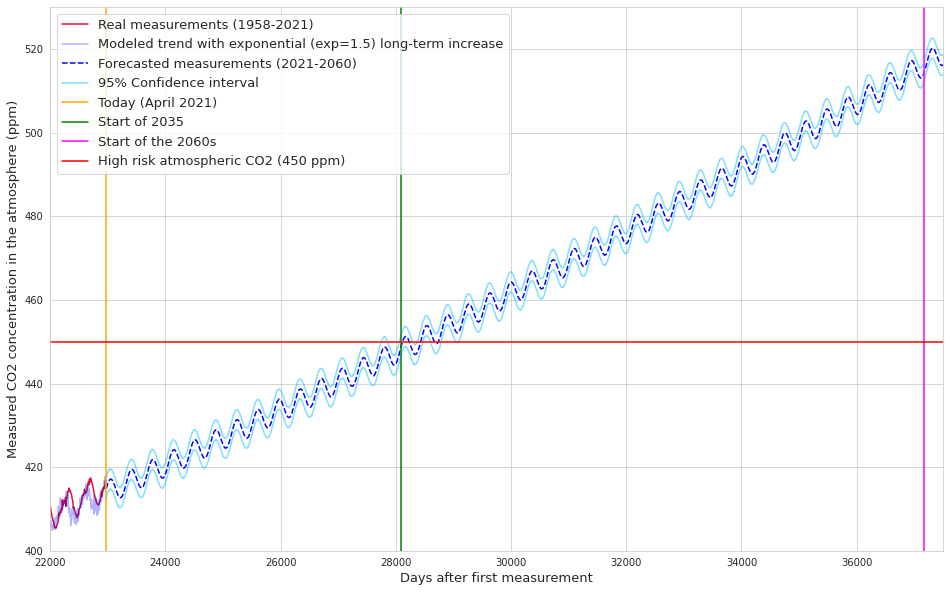

In [57]:
#Visualize modeled values + predictions
plt.figure(figsize=(16,10))
plt.axis([22000, 37500, 400, 530])
plt.plot(days_after_first_measurement, imported_data.iloc[:,1], color='crimson', label='Real measurements (1958-2021)')
plt.plot(days_after_first_measurement, exp_model_data, color='blue',
         label= 'Modeled trend with exponential (exp=1.5) long-term increase',alpha=0.3)
plt.plot(future_days, prediction_values, 'b--', label='Forecasted measurements (2021-2060)')
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[0,:],
         label='95% Confidence interval',color='deepskyblue', alpha=0.5) 
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[1,:],
         color='deepskyblue', alpha=0.5)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)

plt.axvline(days_after_first_measurement[-1], color='orange', label='Today (April 2021)')
plt.axvline(28090, color='green', label='Start of 2035')
plt.axvline(37163, color='fuchsia', label='Start of the 2060s')
plt.axhline(450, color='red', label='High risk atmospheric CO2 (450 ppm)')
sns.set_style("whitegrid")
plt.legend(fontsize=13, loc='upper left')
plt.show()

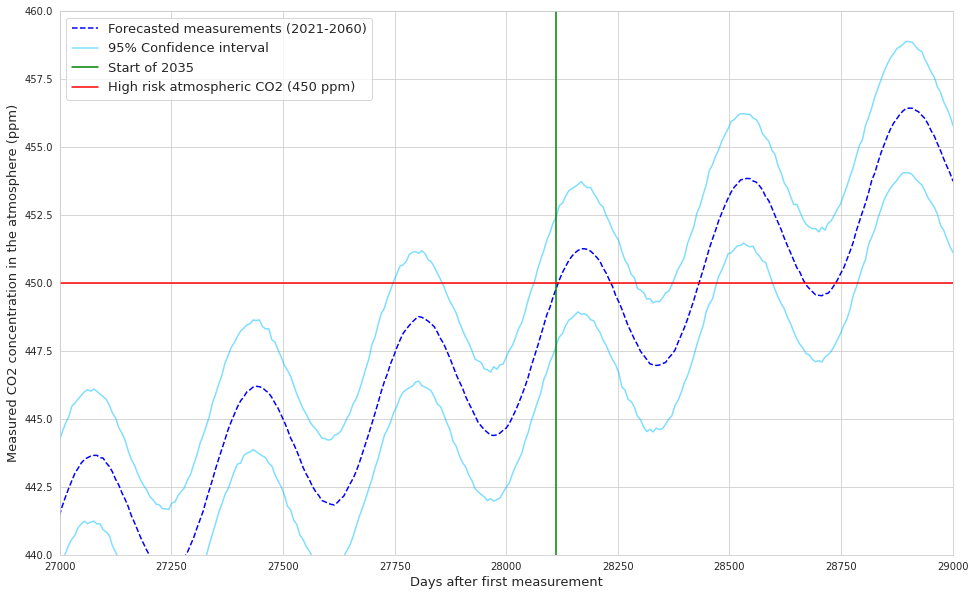

In [66]:
#Visualize modeled values + predictions
plt.figure(figsize=(16,10))
plt.axis([27000, 29000, 440, 460])
plt.plot(future_days, prediction_values, 'b--', label='Forecasted measurements (2021-2060)')
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[0,:],
         label='95% Confidence interval',color='deepskyblue', alpha=0.5) 
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[1,:],
         color='deepskyblue', alpha=0.5)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.axvline(28112, color='green', label='Start of 2035')
plt.axhline(450, color='red', label='High risk atmospheric CO2 (450 ppm)')
sns.set_style("whitegrid")
plt.legend(fontsize=13, loc='upper left')
plt.show()

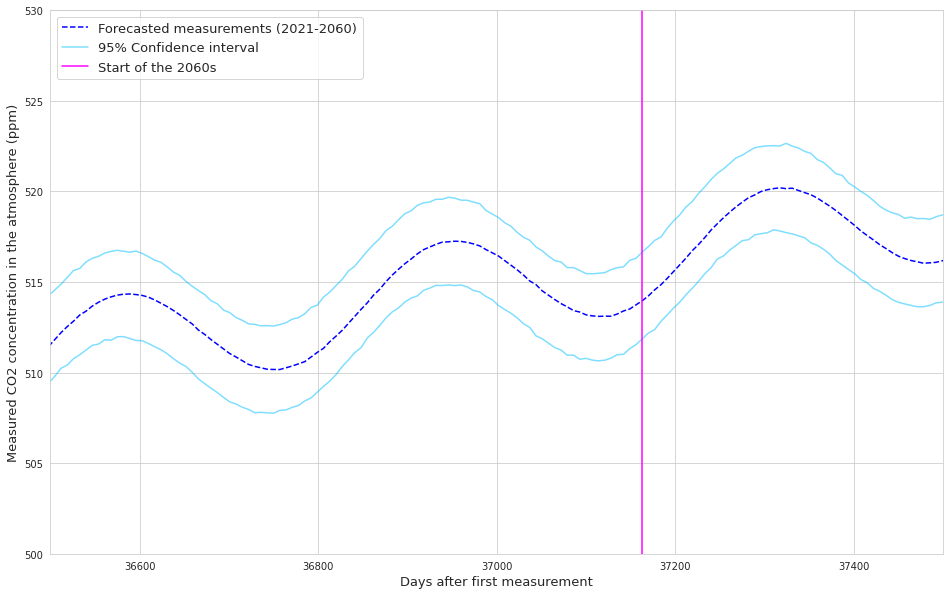

In [72]:
#Visualize modeled values + predictions
plt.figure(figsize=(16,10))
plt.axis([36500, 37500, 500,530])
plt.plot(future_days, prediction_values, 'b--', label='Forecasted measurements (2021-2060)')
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[0,:],
         label='95% Confidence interval',color='deepskyblue', alpha=0.5) 
plt.plot(range(days_after_first_measurement[-1], 37975, 7), prediction_interval[1,:],
         color='deepskyblue', alpha=0.5)
plt.ylabel('Measured CO2 concentration in the atmosphere (ppm)', size=13)
plt.xlabel('Days after first measurement', size=13)
plt.axvline(37163, color='fuchsia', label='Start of the 2060s')
sns.set_style("whitegrid")
plt.legend(fontsize=13, loc='upper left')
plt.show()